In [1]:
import sys
import os

In [2]:
module_path = '/Users/audreina17/Desktop/honest-forests/honest_forests/estimators'
if module_path not in sys.path:
    sys.path.append(module_path)

In [3]:
import numpy as np
from sklearn import datasets
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.model_selection import train_test_split
from sklearn.metrics import brier_score_loss, precision_score, recall_score, f1_score

from adapted_forest import HonestForestClassifier

import matplotlib.pyplot as plt
from matplotlib import cm

## Verifying Isotonic Calib can be used with HF

In [4]:
n_estimators = 100
n_jobs = -2
clf_cv = 5
max_features = 1.0
reps = 5
hfc = HonestForestClassifier(
            n_estimators=n_estimators // clf_cv,
            max_features=max_features,
            n_jobs=n_jobs)
clf = CalibratedClassifierCV(
            base_estimator=hfc,
            method="isotonic",
            cv=clf_cv)

In [5]:
n_samples = 60000
n_bins = 3  # use 3 bins for calibration_curve as we have 3 clusters here

# Generate 3 blobs with 2 classes where the second blob contains
# half positive samples and half negative samples. Probability in this
# blob is therefore 0.5.
centers = [(-5, -5), (0, 0), (5, 5)]
X, y = datasets.make_blobs(
    n_samples=n_samples, centers=centers, shuffle=False, random_state=42
)

y[: n_samples // 2] = 0
y[n_samples // 2 :] = 1
sample_weight = np.random.RandomState(42).rand(y.shape[0])

# split train, test for calibration
X_train, X_test, y_train, y_test, sw_train, sw_test = train_test_split(
    X, y, sample_weight, test_size=0.9, random_state=42
)

## I want to compare the performance of HF+Isotonic Calib vs just HF vs naive RF
### The metric used is Brier Loss, the mean squared difference between the predicted probability and the actual outcome

In [46]:
clf = clf.fit(X_train, y_train)
class_one_probs = clf.predict_proba(X_test)[:, 1]
clf_score = brier_score_loss(y_test, class_one_probs, sample_weight=sw_test)
print("Brier Loss with HF + Isotonic calibration: %1.3f" % clf_score)

Brier Loss with HF + Isotonic calibration: 0.084


In [47]:
naive_hf = HonestForestClassifier(
            n_estimators=n_estimators,
            max_features=max_features,
            n_jobs=n_jobs)
naive_hf = naive_hf.fit(X_train, y_train)
class_one_probs_hf = naive_hf.predict_proba(X_test)[:, 1]
naive_hf_score = brier_score_loss(y_test, class_one_probs_hf, sample_weight=sw_test)
print("Brier Loss with HF + no calibration: %1.3f" % naive_hf_score)

Brier Loss with HF + no calibration: 0.086


In [48]:
naive_rf = RandomForestClassifier(
            n_estimators=n_estimators,
            max_features=max_features,
            n_jobs=n_jobs)
naive_rf = naive_rf.fit(X_train, y_train)
class_one_probs_rf = naive_rf.predict_proba(X_test)[:, 1]
naive_rf_score = brier_score_loss(y_test, class_one_probs_rf, sample_weight=sw_test)
print("Brier Loss with naive rf: %1.3f" % naive_rf_score)

Brier Loss with naive rf: 0.099


In [52]:
naive_rf_for_calib = RandomForestClassifier(
            n_estimators=n_estimators // clf_cv,
            max_features=max_features,
            n_jobs=n_jobs)
iso_rf = CalibratedClassifierCV(
            base_estimator=hfc,
            method="isotonic",
            cv=clf_cv)
iso_rf = iso_rf.fit(X_train, y_train)
class_one_probs_isorf = iso_rf.predict_proba(X_test)[:, 1]
iso_rf_score = brier_score_loss(y_test, class_one_probs_isorf, sample_weight=sw_test)
print("Brier Loss with HF + no calibration: %1.3f" % iso_rf_score)

Brier Loss with HF + no calibration: 0.084


## Seems like on small scaled toy tests, HF+Isotonic Calib slightly outperforms naive HF. 
## However, the performance is almost idential to naive RF+Isotonic Calib.
### All of them outperform RF though.

## Let's see how the plots look like:

In [42]:
def likelihood(X):
    lik1 = np.prod(np.exp(-0.5 * (X) ** 2), axis=1) + np.prod(
        np.exp(-0.5 * (X - np.asarray([5, 5])) ** 2), axis=1
    )
    lik0 = np.prod(np.exp(-0.5 * (X) ** 2), axis=1) + np.prod(
        np.exp(-0.5 * (X - np.asarray([-5, -5])) ** 2), axis=1
    )
    return lik1 / (lik1 + lik0)

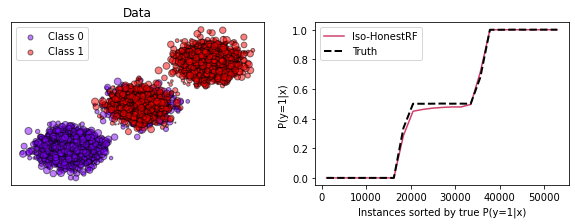

In [44]:
fig, axes = plt.subplots(1, 2, figsize=(10, 3))
y_unique = np.unique(y)
colors = cm.rainbow(np.linspace(0.0, 1.0, y_unique.size))

for this_y, color in zip(y_unique, colors):
    this_X = X_train[y_train == this_y]
    this_sw = sw_train[y_train == this_y]
    axes[0].scatter(
        this_X[:, 0],
        this_X[:, 1],
        s=this_sw * 50,
        c=color[np.newaxis, :],
        alpha=0.5,
        edgecolor="k",
        label="Class %s" % this_y,
    )
axes[0].legend(loc="best")
axes[0].set_title("Data")
axes[0].set_xticks([])
axes[0].set_yticks([])


order = np.lexsort((class_one_probs,))
axes[1].plot(
    np.linspace(0, y_test.size, 51)[1::2],
    class_one_probs[order].reshape(25, -1).mean(1),
    c="#ce406b",
    label="Iso-HonestRF",
)

true_class_one_probs = likelihood(X_test)
true_order = np.lexsort((true_class_one_probs,))
axes[1].plot(
    np.linspace(0, y_test.size, 51)[1::2],
    true_class_one_probs[order].reshape(25, -1).mean(1),
    "k",
    linewidth=2,
    ls="--",
    label=r"Truth",
)

axes[1].set_ylim([-0.05, 1.05])
axes[1].set_xlabel("Instances sorted by true P(y=1|x)")
axes[1].set_ylabel("P(y=1|x)")
axes[1].legend(loc="upper left")

## Comparing with other RF family classifiers

In [45]:
color_dict = {
    "HonestRF": "#F41711",
    "Iso-HonestRF": "#ce406b",
    "RF": "#1b9e77",
    "SigRF": "#377eb8",
    "IRF": "#fdae61",
}

In [49]:
clfs = [
    (
        "HonestRF",
        HonestForestClassifier(
            n_estimators=n_estimators,
            max_features=max_features,
            n_jobs=n_jobs,
        ),
    ),
    (
        "Iso-HonestRF",
        CalibratedClassifierCV(
            base_estimator=HonestForestClassifier(
                n_estimators=n_estimators // clf_cv,
                max_features=max_features,
                n_jobs=n_jobs,
            ),
            method="isotonic",
            cv=clf_cv,
        ),
    ),
    (
        "IRF",
        CalibratedClassifierCV(
            base_estimator=RandomForestClassifier(
                n_estimators=n_estimators // clf_cv,
                max_features=max_features,
                n_jobs=n_jobs,
            ),
            method="isotonic",
            cv=clf_cv,
        ),
    ),
    (
        "SigRF",
        CalibratedClassifierCV(
            base_estimator=RandomForestClassifier(
                n_estimators=n_estimators // clf_cv,
                max_features=max_features,
                n_jobs=n_jobs,
            ),
            method="sigmoid",
            cv=clf_cv,
        ),
    ),
    (
        "RF",
        RandomForestClassifier(
            n_estimators=n_estimators, n_jobs=n_jobs, max_features=max_features
        ),
    ),
]

In [50]:
class_one_probs = {}
for name, clf in clfs:
    clf = clf.fit(X_train, y_train)
    class_one_probs[name] = clf.predict_proba(X_test)[:, 1]

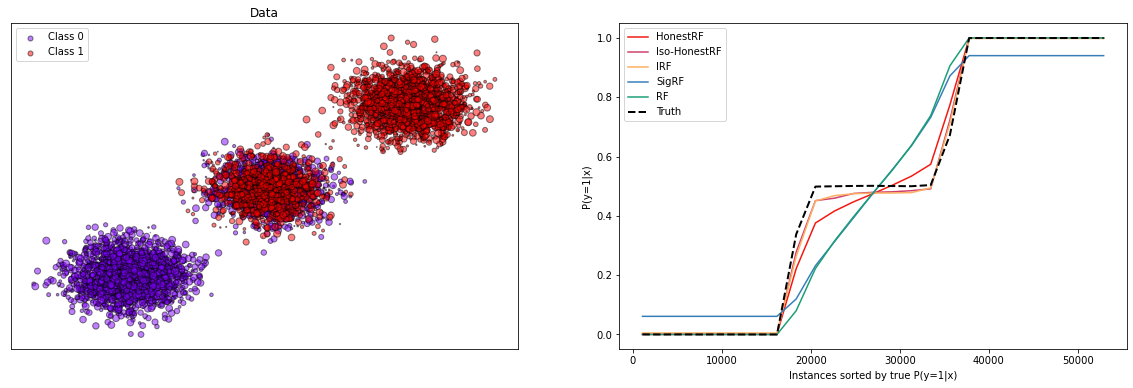

In [53]:
fig, axes = plt.subplots(1, 2, figsize=(20, 6))
y_unique = np.unique(y)
colors = cm.rainbow(np.linspace(0.0, 1.0, y_unique.size))

for this_y, color in zip(y_unique, colors):
    this_X = X_train[y_train == this_y]
    this_sw = sw_train[y_train == this_y]
    axes[0].scatter(
        this_X[:, 0],
        this_X[:, 1],
        s=this_sw * 50,
        c=color[np.newaxis, :],
        alpha=0.5,
        edgecolor="k",
        label="Class %s" % this_y,
    )
axes[0].legend(loc="best")
axes[0].set_title("Data")
axes[0].set_xticks([])
axes[0].set_yticks([])


order = np.lexsort((class_one_probs,))
for clf_name, probs in class_one_probs.items():
    order = np.lexsort((probs,))
    axes[1].plot(
        np.linspace(0, y_test.size, 51)[1::2],
        probs[order].reshape(25, -1).mean(1),
        c=color_dict[clf_name],
        label=clf_name,
    )

true_class_one_probs = likelihood(X_test)
true_order = np.lexsort((true_class_one_probs,))
axes[1].plot(
    np.linspace(0, y_test.size, 51)[1::2],
    true_class_one_probs[order].reshape(25, -1).mean(1),
    "k",
    linewidth=2,
    ls="--",
    label=r"Truth",
)

axes[1].set_ylim([-0.05, 1.05])
axes[1].set_xlabel("Instances sorted by true P(y=1|x)")
axes[1].set_ylabel("P(y=1|x)")
axes[1].legend(loc="upper left")

## If observing closely, one will find the two lines for Isotonic Calib + naive RF vs Isotonic Calib + HF are almost overlapping.